In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import backtrader as bt
import datetime  # For datetime objects
import os.path  # To manage paths
from dotenv import load_dotenv
load_dotenv()
ticker = 'NVDA'


row_daily_stock_path = os.getenv("ROW_DAILY_STOCK_PATH")
csv_file_path = os.path.join(
    row_daily_stock_path, f'{ticker}.csv')

data = bt.feeds.YahooFinanceCSVData(
    dataname=csv_file_path,
    fromdate=datetime.datetime(2010, 1, 1),
    todate=datetime.datetime(2024, 7, 9),
    reverse=True)

YahooFinance csv format:

```text
Date,Open,High,Low,Close,Adj Close,Volume
2019-07-12, 
```
```python
reverse=False
```

My csv format:
```text
date,open,high,low,close,adjusted_close,volume,dividend,split_coefficient
2024-07-09,
```
```python
reverse=True
```

In [17]:
class TestStrategy(bt.Strategy):
    # params = (
    #     ('exitbars', 5),
    # )
    params = (
        ('maperiod', 15),
        ('printlog', False),
    )

    def log(self, txt, dt=None, doprint=False):
        ''' Logging function for this strategy'''
        if True:
        # if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add a MovingAverageSimple indicator
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], 
            period=self.params.maperiod)

        # Indicators for the plotting show
        # bt.indicators.ExponentialMovingAverage(self.datas[0], period=25)
        # bt.indicators.WeightedMovingAverage(self.datas[0], period=25,
        #                                     subplot=True)
        # bt.indicators.StochasticSlow(self.datas[0])
        # bt.indicators.MACDHisto(self.datas[0])
        # rsi = bt.indicators.RSI(self.datas[0])
        # bt.indicators.SmoothedMovingAverage(rsi, period=10)
        # bt.indicators.ATR(self.datas[0], plot=False)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            self.log('ORDER ACCEPTED/SUBMITTED', dt=order.created.dt)
            self.order = order
            return

        if order.status in [order.Expired]:
            self.log('BUY EXPIRED')
            
        elif order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])
        self.log('DrawDown: %.2f' % self.stats.drawdown.drawdown[-1])
        self.log('MaxDrawDown: %.2f' % self.stats.drawdown.maxdrawdown[-1])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:
            # if self.dataclose[0] < self.dataclose[-1] and self.dataclose[-1] < self.dataclose[-2]:
            if self.dataclose[0] > self.sma[0]:
                self.log('BUY CREATE, %.2f' % self.dataclose[0])
                self.order = self.buy()

        else:
            # if len(self) >= (self.bar_executed + self.params.exitbars):
            if self.dataclose[0] < self.sma[0]:
                self.log('SELL CREATE, %.2f' % self.dataclose[0])
                self.order = self.sell()

    def stop(self):
        self.log('(MA Period %2d) Ending Value %.2f' %
                 (self.params.maperiod, self.broker.getvalue()), doprint=True)


# Create a cerebro entity
cerebro = bt.Cerebro()

cerebro.addobserver(bt.observers.DrawDown)

# Add a strategy
cerebro.addstrategy(TestStrategy)
# strats = cerebro.optstrategy(
#     TestStrategy,
#     maperiod=range(10, 31))

# Add the Data Feed to Cerebro
cerebro.adddata(data)

In [20]:
# Set our desired cash start
cerebro.broker.setcash(100000.0)

# Add a FixedSize sizer according to the stake
cerebro.addsizer(bt.sizers.FixedSize, stake=50)

# Set the commission - 0.1% ... divide by 100 to remove the %
cerebro.broker.setcommission(commission=0.001)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
cerebro.run(maxcpus=1)

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
2010-01-25, Close, 0.38
2010-01-25, DrawDown: 0.00
2010-01-25, MaxDrawDown: 0.00
2010-01-26, Close, 0.37
2010-01-26, DrawDown: 0.00
2010-01-26, MaxDrawDown: 0.00
2010-01-27, Close, 0.38
2010-01-27, DrawDown: 0.00
2010-01-27, MaxDrawDown: 0.00
2010-01-28, Close, 0.37
2010-01-28, DrawDown: 0.00
2010-01-28, MaxDrawDown: 0.00
2010-01-29, Close, 0.35
2010-01-29, DrawDown: 0.00
2010-01-29, MaxDrawDown: 0.00
2010-02-01, Close, 0.38
2010-02-01, DrawDown: 0.00
2010-02-01, MaxDrawDown: 0.00
2010-02-02, Close, 0.38
2010-02-02, DrawDown: 0.00
2010-02-02, MaxDrawDown: 0.00
2010-02-03, Close, 0.39
2010-02-03, DrawDown: 0.00
2010-02-03, MaxDrawDown: 0.00
2010-02-03, BUY CREATE, 0.39
2010-02-04, BUY EXECUTED, Price: 0.38, Cost: 19.00, Comm 0.02
2010-02-04, Close, 0.36
2010-02-04, DrawDown: 0.00
2010-02-04, MaxDrawDown: 0.00
2010-02-04, SELL CREATE, 0.36
2010-02-05, SELL EXECUTED, Price: 0.36, Cost: 19.00, Comm 0.02
2010-02-05, OPERATION PROFIT, GROSS -1.00, NET -1.0

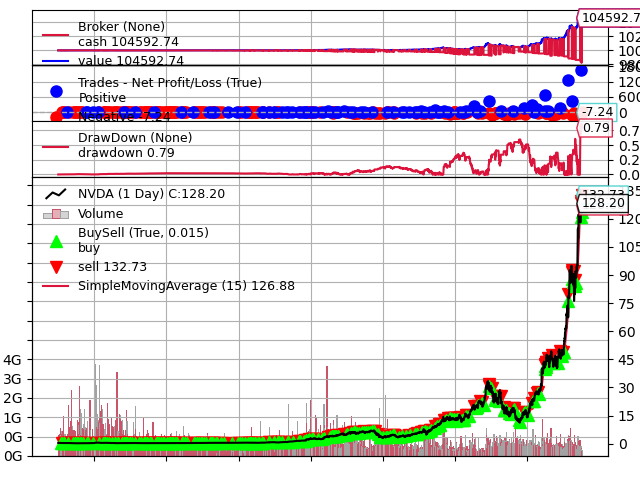

[[<Figure size 640x480 with 5 Axes>]]

In [21]:
# import matplotlib.pyplot as plt

# %matplotlib inline
# import warnings
# warnings.filterwarnings('ignore')
# %matplotlib ipympl
%matplotlib widget

# Plot the result
cerebro.plot(iplot = False)
# cerebro.plot()

In [ ]:
# from backtesting import Backtest, Strategy
# from backtesting.lib import crossover

# from backtesting.test import SMA, GOOG


# class SmaCross(Strategy):
#     def init(self):
#         price = self.data.Close
#         self.ma1 = self.I(SMA, price, 10)
#         self.ma2 = self.I(SMA, price, 20)

#     def next(self):
#         if crossover(self.ma1, self.ma2):
#             self.buy()
#         elif crossover(self.ma2, self.ma1):
#             self.sell()


# bt = Backtest(GOOG, SmaCross, commission=.002,
#               exclusive_orders=True)
# stats = bt.run()
# bt.plot()

In [27]:
import numpy as np
import talib

close = np.random.random(100)
close

array([4.26718533e-01, 8.22195167e-01, 1.51957312e-01, 7.21366900e-01,
       6.53582925e-01, 2.51131025e-01, 3.27546842e-01, 2.97732112e-01,
       6.73591092e-01, 5.42879898e-01, 3.54139399e-01, 9.85607632e-01,
       2.01303745e-02, 8.34006820e-01, 5.77909017e-01, 4.54288422e-01,
       5.55834226e-01, 4.80711099e-01, 6.00067205e-01, 9.52847313e-01,
       5.12604800e-01, 5.40583894e-01, 4.85392938e-01, 9.78870066e-01,
       2.83063638e-01, 9.90134014e-01, 4.32468529e-01, 3.53218784e-01,
       9.45626343e-01, 7.66043677e-01, 1.45040590e-01, 4.36159016e-01,
       9.56355486e-01, 1.44506908e-01, 9.12722382e-01, 6.76432099e-01,
       4.43207815e-01, 5.24952350e-01, 3.23459376e-02, 9.31396205e-01,
       8.35011338e-01, 8.49346418e-01, 9.67607728e-01, 7.13121192e-01,
       6.05943529e-01, 4.26242572e-01, 2.80328463e-01, 4.57534377e-01,
       9.15012350e-01, 2.50865902e-01, 2.88246756e-01, 2.05993858e-01,
       2.93615099e-01, 4.06786117e-01, 7.11644832e-01, 1.57425559e-01,
      

In [29]:
output = talib.SMA(close)
output

array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan, 0.56574167,
       0.5563524 , 0.54348453, 0.5702978 , 0.55106914, 0.55970712,
       0.57388382, 0.57773919, 0.58531319, 0.56393836, 0.5768889 ,
       0.59291796, 0.58837592, 0.6199585 , 0.61592898, 0.61686346,
       0.6159286 , 0.60674508, 0.60597252, 0.61647069, 0.59307131,
       0.58559271, 0.57443971, 0.56804711, 0.54897765, 0.56326369,
       0.53550674, 0.54195547, 0.54930236, 0.53202004, 0.51195349,
       0.52148598, 0.5194931 , 0.49757271, 0.50272318, 0.48064226,
       0.48219637, 0.48576255, 0.49644751, 0.50973404, 0.48873682,
       0.46660089, 0.44331685, 0.42431436, 0.4044916 , 0.39838

In [26]:
from talib import MA_Type
upper, middle, lower = talib.BBANDS(close, matype=MA_Type.T3)